In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI 
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
import os 
# Load environment variables from .env file
load_dotenv()

# Access API keys
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

system_prompt = '''You are a helpful finance expert named Wakasiaka in year 2024. First of all you create a plan to get answer to the research query. 
Then you use tools to get answers to the questions. Finally you use the answers to each question in the plan to give your final verdict.'''

llm = ChatOpenAI(model = "gpt-4o-mini",openai_api_key= openai_api_key )
tools = [TavilySearchResults(max_results = 3, tavily_api_key=tavily_api_key)]
agent_executor = create_react_agent(llm, tools, state_modifier = system_prompt)


In [96]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")
if tavily_api_key:
    print("Tavily API key loaded successfully.")
else:
    print("Error: Tavily API key is missing!")

Tavily API key loaded successfully.


In [ ]:
# To install, run: pip install tavily-python
from tavily import TavilyClient

client = TavilyClient(api_key=tavily_api_key")

response = client.search(
    query="what are the latest updates on Tesla"
)

print(response)
print(response)


{'query': 'what are the latest updates on Tesla', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Tesla Software Updates - February 2025 - AutoPilot Review', 'url': 'https://www.autopilotreview.com/latest-tesla-autopilot-updates/', 'content': 'Latest Tesla Autopilot Software Updates Tesla continually improves its electric vehicles with over-the-air software updates that include enhancements to Autopilot, legacy “Enhanced Autopilot”, and Full Self-Driving (FSD) features in the future. Was There a Tesla Software Update Today? Tesla Software Updates 2025 Listed below are the latest major software updates with notable Tesla Autopilot improvements mentioned in the release notes. 2024.44.25 – (including 2024.44.25.2, 2024.44.25.3) Holiday Update November 2024 Software Updates February 2024 Software Updates January 2024 Software Updates 2023.44.25 (and 2023.44.25.1) – The 2023 Holiday Update includes: November 2023 Software Updates October 2023 Software Updat

In [ ]:
import requests

# Set your API key here
api_key = tavily_api_key

# Tavily API endpoint
url = "https://api.tavily.com/search"

# Define the payload (POST request format)
payload = {
    "query": "latest updates on Tesla",
    "max_results": 3  # Optional: Limit the number of results
}

# Set headers
headers = {
    "Content-Type": "application/json",
    "x-api-key": api_key  # Tavily API expects the key in headers
}

# Make the request
response = requests.post(url, json=payload, headers=headers)

# Print the response
print("Status Code:", response.status_code)
print("Response JSON:", response.json())


Status Code: 401
Response JSON: {'detail': {'error': 'Unauthorized: missing or invalid API key.'}}


In [ ]:
import operator
from pydantic import BaseModel, Field
from typing import Annotated,List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    plan_steps: Annotated[List[Tuple], operator.add]
    response: str

class Plan(BaseModel):
    """ plan to follow in the future """

    steps: List[str] = Field(
        description= "diffeerent steps to follow, should be in sorted order"
    )


In [88]:
from langchain_core.prompts import ChatPromptTemplate
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a finance research agent working in Oct 2024. For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer.
 Do not add any superfluous steps. The result of the final step should be the final answer. 
 Make sure that each step has all the information needed - do not skip steps. 
At the end use the info collected to give the final answer to the main question containing the facts."""
        ),
        ("placeholder", "{messages}"),
    ]
)

In [89]:
planner = planner_prompt | ChatOpenAI(
    model = "gpt-4o-mini", temperature= 0,openai_api_key = openai_api_key
).with_structured_output(Plan)

planner.invoke(
    {
        "messages": [
            ("user", "Should we Invest in tesla given the curret situation of EV?")
        ]
    }
)



AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: KKK. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [90]:
from typing import Union

class Response(BaseModel):
    '''Response To user'''
    response: str 

class Act(BaseModel):
    """ Action to perform"""

    action: Union[Response,Plan] = Field(
        description= " Action to perform. If you waant to respond to user , use Response."
        "If you need to further use tools to get the answer, use plan "
    )
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all 
the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user,
then respond with that. otherwise, fill out the plan. Only add steps the plan that still
need to be done. Do not return previously done steps as part of the plan.

"""
)
replanner = replanner_prompt | ChatOpenAI(
    model = "gpt-4o", temperature=0, openai_api_key = openai_api_key
).with_structured_output(Act)



In [91]:
from typing import Literal
from langgraph.graph import END

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}" for i , step in enumerate(plan))
    task = plan[0]
    task_formatted =f"""For the following plan:
    {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user",state["input"])]})
    return {"plan":plan.steps}

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}
    
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"





In [92]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")
workflow.add_edge(START, "planner")

workflow.add_conditional_edges(
   "replan",
   should_end,
   ["agent", END], 
)

app = workflow.compile()

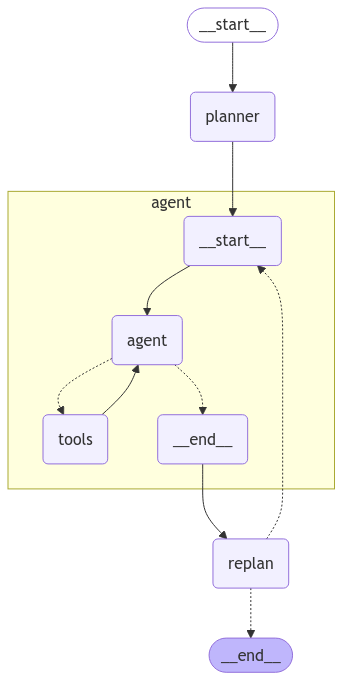

In [93]:
from IPython.display import Image, display
display(Image(app.get_graph(xray = True).draw_mermaid_png()))

In [94]:
import promptquality as pq
gpt4o_scorer = pq.CustomizedChainPollScorer(
                         scorer_name = pq.CustomizedScorerName.context_adherence_plus,
                         model_alias=pq.SupportedModels.gpt_4o,
                         num_judges=3)


In [95]:
# input = {"input":"should we invest in tesla in the given current situation of EV"}
# app.invoke(input)
# evaluate_handler = pq.GalileoPromptCallback(project_name='Wakasiaka-research-agent',run_name=f"test",scorers=[gpt4o_scorer])
# config = {"recursion_limit": 30, "callbacks": [evaluate_handler]}
# Define a test query
# Ensure the agent gets the right input format
test_query = "What are the key financial risks of investing in tech startups?"

# Running the agent
response = agent_executor.invoke({"messages": [{"role": "user", "content": test_query}]})

# Print the result
print("Agent Response:\n", response)


Agent Response:
 {'messages': [HumanMessage(content='What are the key financial risks of investing in tech startups?', additional_kwargs={}, response_metadata={}, id='a8d04acf-9d73-4576-a811-52431c259684'), AIMessage(content='To address the research query regarding the key financial risks of investing in tech startups, I will create a plan to gather comprehensive information on this topic. Here’s the plan:\n\n1. **Identify Common Financial Risks**: Search for general financial risks associated with investing in tech startups, including market volatility, funding challenges, and exit strategy risks.\n  \n2. **Examine Specific Risks**: Look for specific risks that are unique to the tech industry, such as rapid technological change, competition, and regulatory challenges.\n\n3. **Gather Expert Opinions**: Find insights from financial experts or investment platforms that specialize in tech startups to understand their perspectives on the risks involved.\n\n4. **Analyze Case Studies**: Look

In [52]:
inputs = {"input": "should we invest in Tesla given the current situation of EV?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)



NameError: name 'config' is not defined

In [102]:
test_query = "What are the key financial risks of investing in tech startups?"

# Run the agent
response = agent_executor.invoke({"messages": [{"role": "user", "content": test_query}]})

# Debug: Check if API calls were triggered
print("Agent Response:\n", response)
print("\nTool Calls Made:\n", response.get("messages", [])[1].get("tool_calls", []))


Agent Response:
 {'messages': [HumanMessage(content='What are the key financial risks of investing in tech startups?', additional_kwargs={}, response_metadata={}, id='b8814903-ce33-4805-bec1-16d8d48f6464'), AIMessage(content='To address the research query on the key financial risks of investing in tech startups, I will follow this plan:\n\n1. **Identify Common Financial Risks**: Research and compile a list of common financial risks associated with investing in tech startups.\n2. **Analyze Specific Risks**: Look into specific financial risks such as market volatility, funding challenges, and operational costs.\n3. **Consider External Factors**: Investigate how external factors like economic downturns or regulatory changes can impact tech startups financially.\n4. **Review Expert Opinions**: Find insights from financial experts or recent articles that discuss the risks of investing in tech startups.\n\nNow, I will utilize the tools available to gather information on these points.', addit

AttributeError: 'AIMessage' object has no attribute 'get'